# Compare different initial parameters to measurements

In [1]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pybt
from pybt.tools.parsers import read_twiss_file
from pybt.tools.plotters import *
import pandas as pd
from scipy import stats
import json
import ipywidgets as widgets
from ipywidgets import Button, Layout
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from os import walk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
import pickle

In [2]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

In [3]:
# Initial conditions East Area codilog
betx0 = 82.4
bety0 = 33.2
alfx0 = -11.1
alfy0 = 0.28
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 1.5e-6
eyn =  1.5e-6
sige = 0.001

In [4]:
# # Initial conditions East Area
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

In [5]:
# # Initial conditions East Area corrected by hand
# betx0 = 154.0835045206266
# bety0 = 5.222566527078791
# alfx0 = -36.90472944993891
# alfy0 = 0.2523074897915478
# Dx0 = 0.13
# Dy0 = 0.0
# Dpx0 = 0.02
# Dpy0 = 0.0
# exn = 0.00003
# eyn =  0.000005
# sige = 0.000679

In [6]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

# Open Data

In [7]:
start_path = "/eos/home-e/eljohnso/SWAN_projects/quad-scan-east/df/large_df/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [8]:
filenames

['df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle',
 'df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle',
 'df_quad_scan_east_slow_ions_high_energy_2022_09_26_15h31m15s.pickle',
 'df_quad_scan_east_slow_ions_high_energy_2022_09_26_16h00m25s.pickle',
 'df_quad_scan_east_slow_ions_high_energy_2022_09_26_16h50m24s.pickle',
 'df_quad_scan_east_slow_ions_low_energy_2022_09_27_11h28m57s.pickle',
 'df_quad_scan_east_slow_ions_low_energy_2022_09_27_12h40m58s.pickle',
 'df_quad_scan_east_slow_ions_low_energy_2022_09_27_13h10m38s.pickle']

df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle


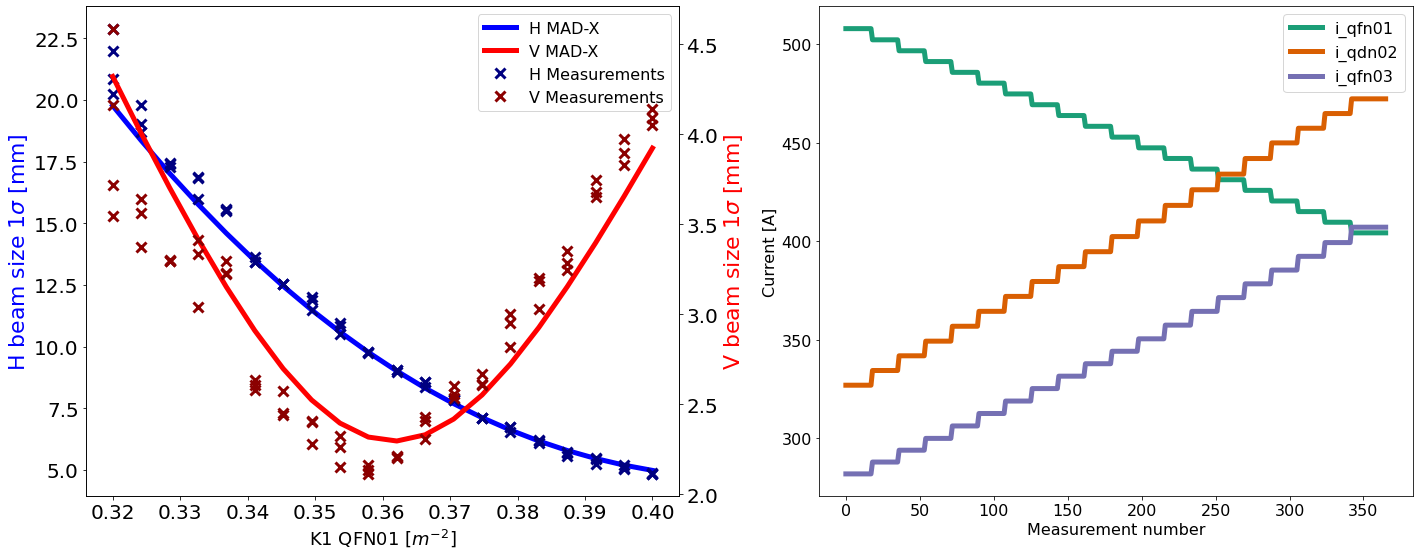

In [9]:
df = pd.DataFrame()

subset_dirnames = filenames[0]
with open(start_path+subset_dirnames, 'rb') as handle:
    df_i = pickle.load(handle)
    print(subset_dirnames)
df = pd.concat([df,df_i])

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

H_sigma_madx = []
V_sigma_madx = []
for i in range(len(df.k_qfn01.unique())):
    k_qfn01 = df.k_qfn01.unique()[i]
    k_qdn02 = df.k_qdn02.unique()[i]
    k_qfn03 = df.k_qfn03.unique()[i]

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(20,8), tight_layout=True)
ax2 = ax[0].twinx()

#MAD-X
plot1 = ax[0].plot(df.k_qfn01.unique(), np.array(H_sigma_madx)*1000, linewidth=5, color="b", zorder=0, label="H MAD-X")
plot2 = ax2.plot(df.k_qfn01.unique(), np.array(V_sigma_madx)*1000, linewidth=5, color="r", zorder=0, label="V MAD-X")

ax[0].set_xlabel("K1 QFN01 [$m^{-2}$]", fontsize=18)
ax[0].set_ylabel("H beam size $1\sigma$ [mm]", fontsize=22, color="b")

ax2.set_ylabel("V beam size $1\sigma$ [mm]", fontsize=22, color="r")


# Plot the measurements
plot3 = ax[0].plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptH3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="navy", label="H Measurements")
plot4 = ax2.plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptV3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="darkred", label="V Measurements")

# fig.suptitle(f"East Dump Quadrupole scan \n Filename: {subset_dirnames}", fontsize=18)

plots = plot1+plot2+plot3+plot4
labs = [l.get_label() for l in plots]
ax[0].legend(plots, labs, fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=18)


### Currents
for current in ["i_qfn01", "i_qdn02", "i_qfn03"]:
    ax[1].plot(df[current], lw = 5, label=current)
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Measurement number")
ax[1].legend()

plt.savefig("fig/east_quad_scan_"+str(subset_dirnames)+".png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# Second data measurement

df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle


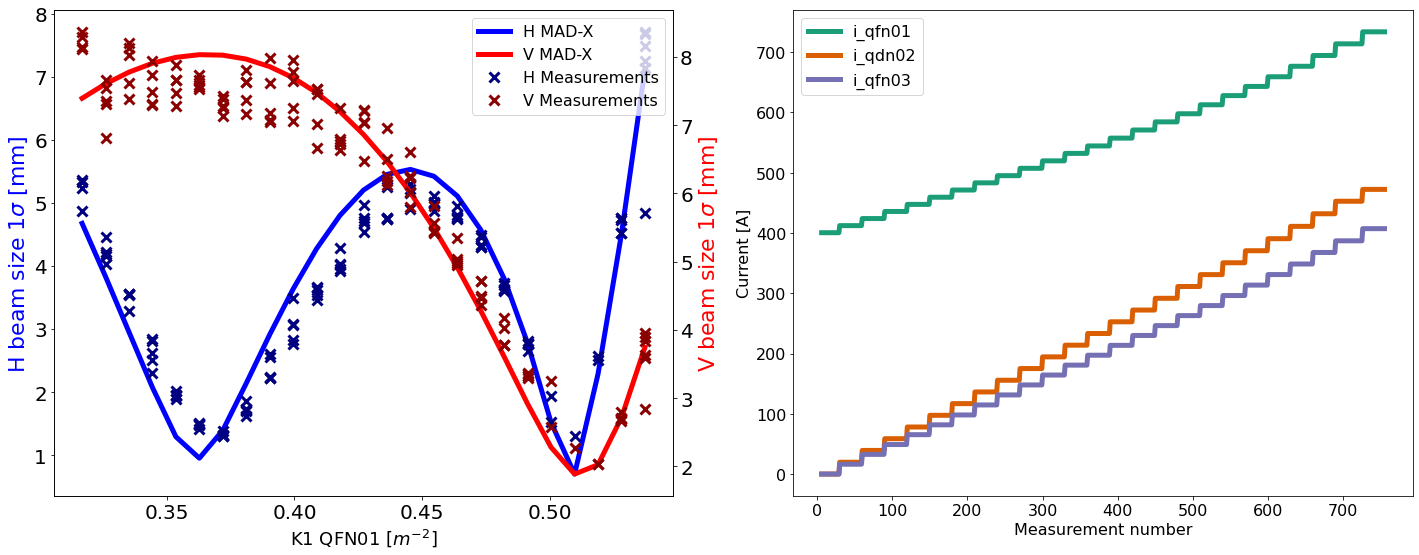

In [10]:
# Open measurement
df = pd.DataFrame()

subset_dirnames = filenames[1]
with open(start_path+subset_dirnames, 'rb') as handle:
    df_i = pickle.load(handle)
    print(subset_dirnames)
df = pd.concat([df,df_i])
df = df.iloc[6:]

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

H_sigma_madx = []
V_sigma_madx = []
for i in range(len(df.k_qfn01.unique())):
    k_qfn01 = df.k_qfn01.unique()[i]
    k_qdn02 = df.k_qdn02.unique()[i]
    k_qfn03 = df.k_qfn03.unique()[i]

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(20,8), tight_layout=True)
ax2 = ax[0].twinx()

#MAD-X
plot1 = ax[0].plot(df.k_qfn01.unique(), np.array(H_sigma_madx)*1000, linewidth=5, color="b", zorder=0, label="H MAD-X")
plot2 = ax2.plot(df.k_qfn01.unique(), np.array(V_sigma_madx)*1000, linewidth=5, color="r", zorder=0, label="V MAD-X")

ax[0].set_xlabel("K1 QFN01 [$m^{-2}$]", fontsize=18)
ax[0].set_ylabel("H beam size $1\sigma$ [mm]", fontsize=22, color="b")

ax2.set_ylabel("V beam size $1\sigma$ [mm]", fontsize=22, color="r")

# Plot the measurements
plot3 = ax[0].plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptH3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="navy", label="H Measurements")
plot4 = ax2.plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptV3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="darkred", label="V Measurements")

# fig.suptitle(f"East Dump Quadrupole scan \n Filename: {subset_dirnames}", fontsize=18)

plots = plot1+plot2+plot3+plot4
labs = [l.get_label() for l in plots]
ax[0].legend(plots, labs, fontsize=16, loc="upper right")

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=18)

### Currents
for current in ["i_qfn01", "i_qdn02", "i_qfn03"]:
    ax[1].plot(df[current], lw = 5, label=current)
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Measurement number")
ax[1].legend()

plt.savefig("fig/east_quad_scan_"+str(subset_dirnames)+".png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# Third measurement

df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle


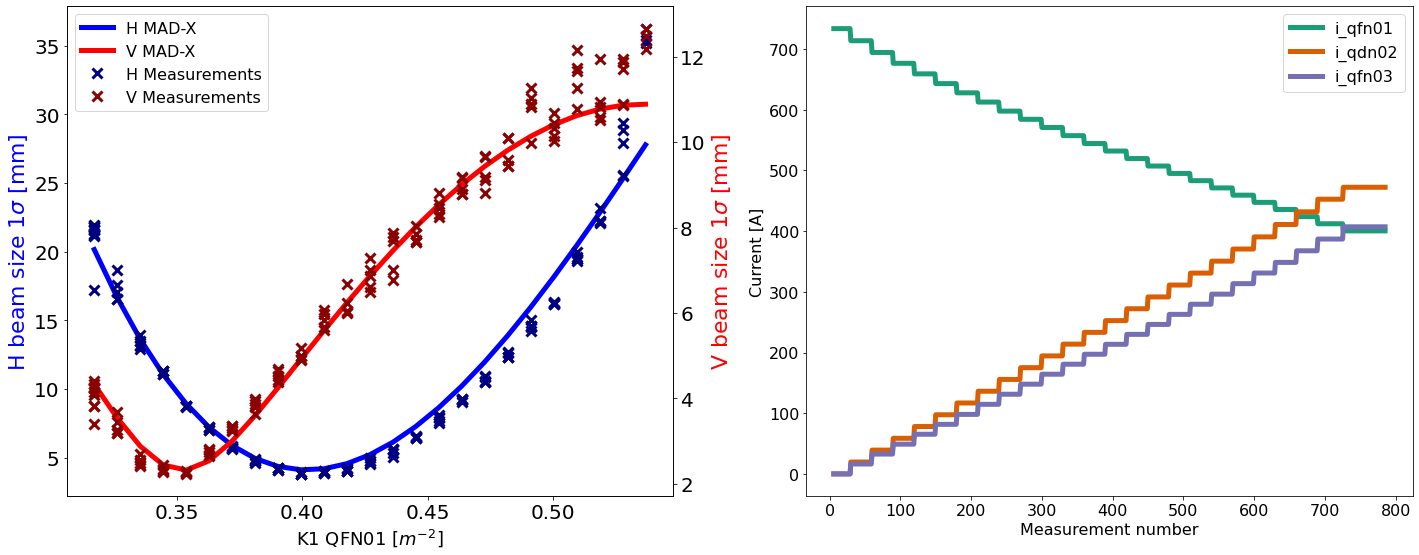

In [11]:
# Open measurement
df = pd.DataFrame()

subset_dirnames = filenames[2]
with open(start_path+subset_dirnames, 'rb') as handle:
    df_i = pickle.load(handle)
    print(subset_dirnames)
df = pd.concat([df,df_i])
df = df.iloc[6:]

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

H_sigma_madx = []
V_sigma_madx = []
for i in range(len(df.k_qfn01.unique())):
    k_qfn01 = df.k_qfn01.unique()[i]
    k_qdn02 = df.k_qdn02.unique()[i]
    k_qfn03 = df.k_qfn03.unique()[i]

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(20,8), tight_layout=True)
ax2 = ax[0].twinx()

#MAD-X
plot1 = ax[0].plot(df.k_qfn01.unique(), np.array(H_sigma_madx)*1000, linewidth=5, color="b", zorder=0, label="H MAD-X")
plot2 = ax2.plot(df.k_qfn01.unique(), np.array(V_sigma_madx)*1000, linewidth=5, color="r", zorder=0, label="V MAD-X")

ax[0].set_xlabel("K1 QFN01 [$m^{-2}$]", fontsize=18)
ax[0].set_ylabel("H beam size $1\sigma$ [mm]", fontsize=22, color="b")

ax2.set_ylabel("V beam size $1\sigma$ [mm]", fontsize=22, color="r")


# Plot the measurements
plot3 = ax[0].plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptH3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="navy", label="H Measurements")
plot4 = ax2.plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptV3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="darkred", label="V Measurements")

# fig.suptitle(f"East Dump Quadrupole scan \n Filename: {subset_dirnames}", fontsize=18)

plots = plot1+plot2+plot3+plot4
labs = [l.get_label() for l in plots]
ax[0].legend(plots, labs, fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=18)

### Currents
for current in ["i_qfn01", "i_qdn02", "i_qfn03"]:
    ax[1].plot(df[current], lw = 5, label=current)
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Measurement number")
ax[1].legend()

plt.savefig("fig/east_quad_scan_"+str(subset_dirnames)+".png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# Fourth Measurement

df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle


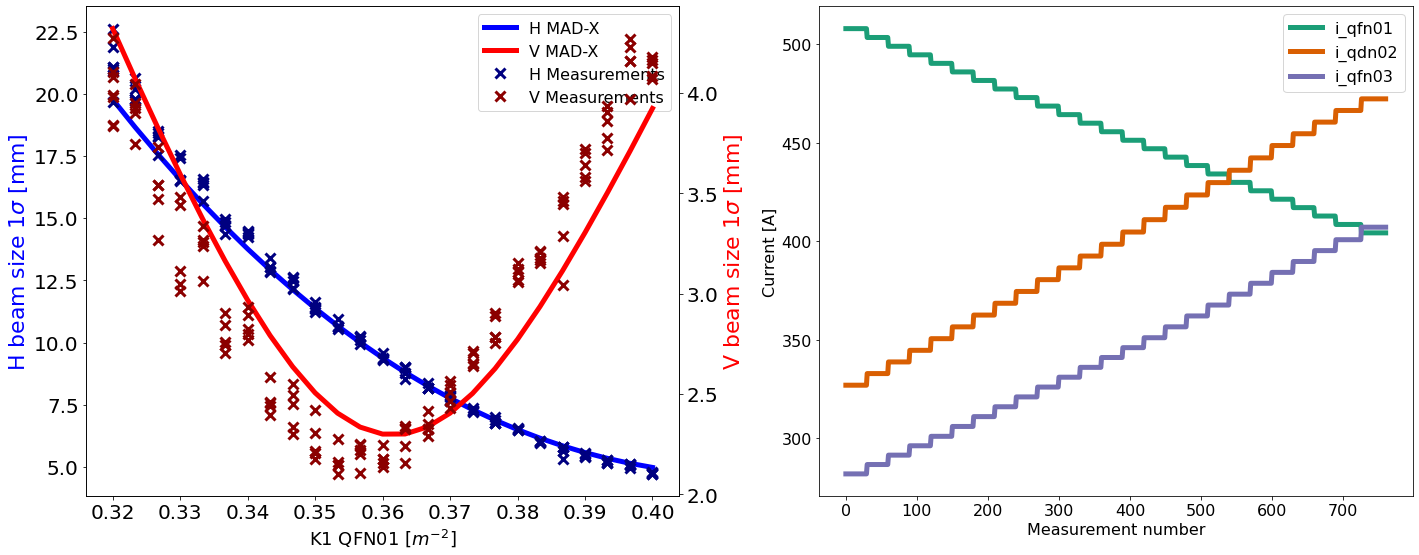

In [120]:
# Open measurement
df = pd.DataFrame()
subset_dirnames = filenames[3]
with open(start_path+subset_dirnames, 'rb') as handle:
    df_i = pickle.load(handle)
    print(subset_dirnames)
df = pd.concat([df,df_i])

#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")


ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

H_sigma_madx = []
V_sigma_madx = []
for i in range(len(df.k_qfn01.unique())):
    k_qfn01 = df.k_qfn01.unique()[i]
    k_qdn02 = df.k_qdn02.unique()[i]
    k_qfn03 = df.k_qfn03.unique()[i]

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")


    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

fig, ax = plt.subplots(1,2, figsize=(20,8), tight_layout=True)
ax2 = ax[0].twinx()

#MAD-X
plot1 = ax[0].plot(df.k_qfn01.unique(), np.array(H_sigma_madx)*1000, linewidth=5, color="b", zorder=0, label="H MAD-X")
plot2 = ax2.plot(df.k_qfn01.unique(), np.array(V_sigma_madx)*1000, linewidth=5, color="r", zorder=0, label="V MAD-X")

ax[0].set_xlabel("K1 QFN01 [$m^{-2}$]", fontsize=18)
ax[0].set_ylabel("H beam size $1\sigma$ [mm]", fontsize=22, color="b")

ax2.set_ylabel("V beam size $1\sigma$ [mm]", fontsize=22, color="r")

# # Box with initial parameters
# textstr = '\n'.join((
#     "Matched initial parameters:",
#     r'$\beta_{x}$='+str(round(betx0,3)),
#     r'$\beta_{y}$='+str(round(bety0,3)),
#     r'$\alpha_{x}$='+str(round(alfx0,3)),
#     r'$\alpha_{y}$='+str(round(alfy0,3)),
#     r'$D_{x}$='+str(round(Dx0,3)),
#     r'$D_{y}$='+str(round(Dy0,3)),
#     r'$D_{px}$='+str(round(Dpx0,3)),
#     r'$D_{py}$='+str(round(Dpy0,3)),
#     r'$exn$='+str(round(exn,8)),
#     r'$eyn$='+str(round(eyn,8)),
#     r'$\frac{dp}{p}$='+str(round(sige,6)),
#     ))

# props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# # place a text box in upper left in axes coords
# ax1.text(0.5, 0.9, textstr, transform=ax1.transAxes, fontsize=12,
#         verticalalignment='top', bbox=props)


# Plot the measurements
plot3 = ax[0].plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptH3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="navy", label="H Measurements")
plot4 = ax2.plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptV3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="darkred", label="V Measurements")

# fig.suptitle(f"East Dump Quadrupole scan \n Filename: {subset_dirnames}", fontsize=18)

plots = plot1+plot2+plot3+plot4
labs = [l.get_label() for l in plots]
ax[0].legend(plots, labs, fontsize=16)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=18)

### Currents
for current in ["i_qfn01", "i_qdn02", "i_qfn03"]:
    ax[1].plot(df[current], lw = 5, label=current)
ax[1].set_ylabel("Current [A]")
ax[1].set_xlabel("Measurement number")
ax[1].legend()

plt.savefig("fig/east_quad_scan_"+str(subset_dirnames)+".png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# BTV96

In [12]:
start_path = "/eos/user/e/eljohnso/SWAN_projects/quad-scan-east/df/t8/"
end_path = ""
mypath = start_path+"/"+end_path

f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [13]:
# Open measurement
df = pd.DataFrame()

subset_dirnames = filenames[0]
with open(start_path+subset_dirnames, 'rb') as handle:
    df_i = pickle.load(handle)
    print(subset_dirnames)
df = pd.concat([df,df_i])

df_meas_btv96.pickle


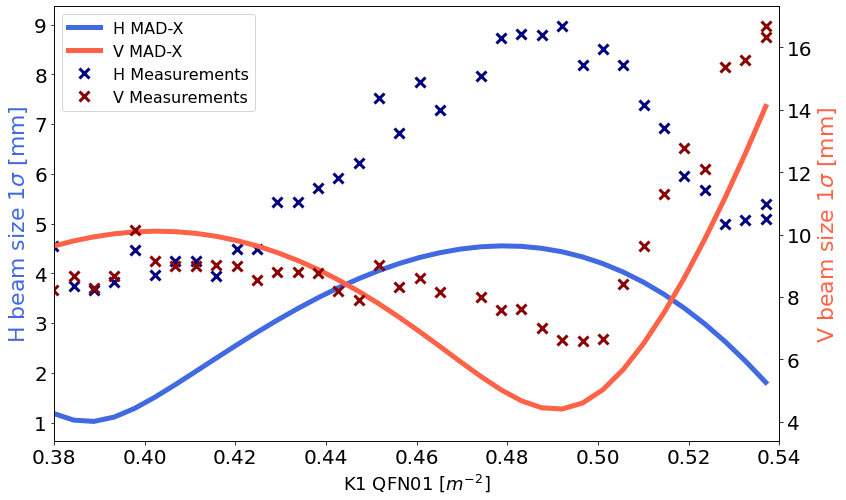

In [14]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61t8/f61t8_op.seq")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')


madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61t8_op;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("F62.BTV002 : MARKER;")
madx.input('SEQEDIT, sequence=f61t8_op;')
madx.input('FLATTEN;')
madx.command.install(element = 'F62.BTV002', at=1.250107+0.406, from_="F61.MBXHD033")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.use(sequence="f61t8_op")

H_sigma_madx = []
V_sigma_madx = []
for i in range(len(df.k_qfn01.unique())):
    k_qfn01 = df.k_qfn01.unique()[i]
    k_qdn02 = df.k_qdn02.unique()[i]
    k_qfn03 = df.k_qfn03.unique()[i]
    
    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")
    madx.input("kQDN4 = -0.09035;")
    madx.input("kQFN5 = 0.196;")
    madx.input("kQDN6 = -0.1946;")
    madx.input("kQDN7 = -0.061403;")
    madx.input("kQFN8 = 0.069031;")

    madx.use(sequence="f61t8_op")
    twiss_f61 = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx.append( beam_size(twiss_f61['betx']["t08.btv096"], twiss_f61['dx']["t08.btv096"], ex, sige, 1) )
    V_sigma_madx.append( beam_size(twiss_f61['bety']["t08.btv096"], twiss_f61['dy']["t08.btv096"], ey, sige, 1) )

fig, ax1 = plt.subplots(figsize=(13,8))
ax2 = ax1.twinx()

#MAD-X
plot1 = ax1.plot(df.k_qfn01.unique(), np.array(H_sigma_madx)*1000, linewidth=5, color="royalblue", zorder=0, label="H MAD-X")
plot2 = ax2.plot(df.k_qfn01.unique(), np.array(V_sigma_madx)*1000, linewidth=5, color="tomato", zorder=0, label="V MAD-X")

ax1.set_xlabel("K1 QFN01 [$m^{-2}$]", fontsize=18)
ax1.set_ylabel("H beam size $1\sigma$ [mm]", fontsize=22, color="royalblue")

ax2.set_ylabel("V beam size $1\sigma$ [mm]", fontsize=22, color="tomato")

# # Box with initial parameters
# textstr = '\n'.join((
#     "Matched initial parameters:",
#     r'$\beta_{x}$='+str(round(betx0,3)),
#     r'$\beta_{y}$='+str(round(bety0,3)),
#     r'$\alpha_{x}$='+str(round(alfx0,3)),
#     r'$\alpha_{y}$='+str(round(alfy0,3)),
#     r'$D_{x}$='+str(round(Dx0,3)),
#     r'$D_{y}$='+str(round(Dy0,3)),
#     r'$D_{px}$='+str(round(Dpx0,3)),
#     r'$D_{py}$='+str(round(Dpy0,3)),
#     r'$exn$='+str(round(exn,8)),
#     r'$eyn$='+str(round(eyn,8)),
#     r'$\frac{dp}{p}$='+str(round(sige,6)),
#     ))

# props = dict(boxstyle='square', facecolor='white', alpha=0.5)

# # place a text box in upper left in axes coords
# ax[0].text(0.7, 0.8, textstr, transform=ax[0].transAxes, fontsize=12,
#         verticalalignment='top', bbox=props, zorder=99)


# Plot the measurements
plot3 = ax1.plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptH3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="navy", label="H Measurements")
plot4 = ax2.plot(df.loc[df.Acqu==3].k_qfn01, df.loc[df.Acqu==3].poptV3_cal, marker="x", markersize=10, mew=3, linestyle="None", color="darkred", label="V Measurements")

plots = plot1+plot2+plot3+plot4
labs = [l.get_label() for l in plots]
ax1.legend(plots, labs, fontsize=16)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='minor', labelsize=18)

ax1.set_xlim(0.38,0.54)

plt.savefig("fig/east_quad_scan_"+str(subset_dirnames)+".png", facecolor='white', transparent=False, dpi = 300, bbox_inches='tight')

# Merging images

In [129]:
from PIL import Image
images_list = ['fig/east_quad_scan_df_quad_scan_east_dump_with_filters_2022_07_05_10h43m20s.pickle.png', 'fig/east_quad_scan_df_quad_scan_east_dump_with_filters_2022_07_04_12h17m49s.pickle.png', 'fig/east_quad_scan_df_quad_scan_east_dump_with_filters_2022_07_05_09h41m36s.pickle.png', 'fig/east_quad_scan_df_quad_scan_east_dump_with_filters_2022_07_05_11h49m14s.pickle.png']
imgs = [Image.open(i) for i in images_list]

# If you're using an older version of Pillow, you might have to use .size[0] instead of .width
# and later on, .size[1] instead of .height
min_img_width = min(i.width for i in imgs)

total_height = 0
for i, img in enumerate(imgs):
    # If the image is larger than the minimum width, resize it
    if img.width > min_img_width:
        imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.ANTIALIAS)
    total_height += imgs[i].height

# I have picked the mode of the first image to be generic. You may have other ideas
# Now that we know the total height of all of the resized images, we know the height of our final image
img_merge = Image.new(imgs[0].mode, (min_img_width, total_height))
y = 0
for img in imgs:
    img_merge.paste(img, (0, y))

    y += img.height
img_merge.save('fig/combine_quadrupole_scan_east_dump.png')

# Smallest beam size and highest density

In [210]:
def draw_aperture_circle(ax, twiss, aper):
    for _, row in twiss[twiss[aper] > 0].iterrows():
        if row["apertype"]=="circle":
            facecolor="k"
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper],facecolor=facecolor))
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper],facecolor=facecolor))
def draw_aperture_rectangle(ax, twiss, aper):
    for _, row in twiss[twiss[aper] > 0].iterrows():
        if row["apertype"]=="rectangle":
            facecolor="k"
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 1), row['l'], -1+row[aper],facecolor=facecolor))
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], -1), row['l'], 1-row[aper],facecolor=facecolor))
def draw_synoptic(ax, twiss):
    fontsize = 16
    offset_s = 0.2
    for _, row in twiss.iterrows():
        label = _
        if (row['keyword'] == 'monitor' and _ != "f61.bctf022" and _ != "f61.bcgaa023"):
            _ = ax.add_patch(mpl.patches.Rectangle( (row['s']-row['l'], 0), row['l'], 0.6, facecolor='r', edgecolor='k'))
            ax.annotate(label,
            xy=(row.s-row.l/2-offset_s, 0.75), xycoords='data',
            xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
        elif (row['keyword'] == 'marker'):
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='r', alpha=0.2, edgecolor='k'))
        elif (row['keyword'] == 'rbend' or row['keyword'] == 'sbend' or row['keyword'] == 'matrix'):
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='lightgreen', edgecolor='k'))
            ax.annotate(label,
                xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
                xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
        elif (row['keyword'] == 'instrument'):
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='magenta', alpha=1.0, edgecolor='k'))
            ax.annotate(label,
                xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
                xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
        elif (row['keyword'] == 'quadrupole'):
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='lightblue', alpha=1.0, edgecolor='k'))
            ax.annotate(label,
                xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
                xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
        elif (row['keyword'] == 'hkicker' or row['keyword'] == 'vkicker'):
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='blue', alpha=1.0, edgecolor='k'))
            ax.annotate(label,
                xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
                xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
        if (label == "dumpwall"):
            _ = ax.add_patch(mpl.patches.Rectangle((row['s']-row['l'], 0), row['l'], 0.6, facecolor='blue', alpha=1.0, edgecolor='k'))
            ax.annotate("Dump wall",
                xy=(row['s']-row['l']/2-offset_s, 0.75), xycoords='data',
                xytext=(0.0, 0.0), textcoords='offset points',rotation=90, fontsize=fontsize)
def k1(current, magnet_type, Brho):
    
    A_Q74L = [0.0,
    5.000978,
    10.000304,
    50.002003,
    100.001404,
    150.001373,
    200.00238,
    250.005432,
    299.993652,
    350.001648,
    399.995728,
    449.994446,
    499.997375,
    549.999878,
    599.994873,
    650.004211,
    666.999146,
    699.991455,
    749.998169,
    799.996643]
    
    T_Q74L = [0.0,
    0.2619,
    0.492968,
    2.358847,
    4.710821,
    7.068205,
    9.426532,
    11.780794,
    14.131984,
    16.4773,
    18.814776,
    21.133094,
    23.416058,
    25.617934,
    27.638804,
    29.43015,
    29.981004,
    30.987122,
    32.347211,
    33.545971]
    
    L_Q74L = 0.74
    
    A_Q120C = [0.00,
    50.00,
    100.00,
    150.00,
    200.00,
    250.00,
    300.00,
    350.00,
    400.00,
    450.00,
    500.00,
    550.00,
    600.00,
    650.00]
    
    T_Q120C = [0.00,
    2.05,
    4.12,
    6.19,
    8.26,
    10.33,
    12.39,
    14.43,
    16.44,
    18.36,
    20.14,
    21.74,
    23.01,
    24.07]
    
    L_Q120C = 1.2
    
    A_QFL = [0,
    94.15,
    145.76,
    197.97,
    250.74,
    300.18,
    350.7,
    402,
    451.15,
    502.09,
    551.47]
    
    T_QFL = [0,
    4.86,
    7.48,
    10.158,
    12.875,
    15.377,
    17.81,
    20.045,
    21.844,
    23.217,
    24.445]
    
    L_QFL = 1.2
    
    A_QFS = [0,
    98.95,
    147.71,
    197.23,
    249.64,
    301.81,
    351.91,
    400.77,
    454.51,
    506.28,
    555.25]
    
    T_QFS = [0,
    3.462,
    5.158,
    6.875,
    8.686,
    10.48,
    12.14,
    13.57,
    14.79,
    15.75,
    16.49]
    
    L_QFS = 0.8
    
    A_Q200L = [0.0,
    5.0,
    10.0,
    50.0,
    100.0,
    150.0,
    200.0,
    250.0,
    300.0,
    350.0,
    400.0,
    450.0,
    500.0,
    540.0,
    600.0,
    650.0,
    700.0,
    750.0,
    800.0,
    850.0]
    
    T_Q200L = [0.0,
    0.20,
    0.38,
    1.85,
    3.69,
    5.54,
    7.39,
    9.23,
    11.08,
    12.91,
    14.74,
    16.54,
    18.28,
    19.58,
    21.34,
    22.57,
    23.57,
    24.38,
    25.08,
    25.67]
    
    L_Q200L = 2.0
    
    if magnet_type == "Q74L":
        measured_currents = A_Q74L
        measured_int_gradient = T_Q74L
        length = L_Q74L
        
    if magnet_type == "Q120C":
        measured_currents = A_Q120C
        measured_int_gradient = T_Q120C
        length = L_Q120C
        
    if magnet_type == "QFL":
        measured_currents = A_QFL
        measured_int_gradient = T_QFL
        length = L_QFL
        
    if magnet_type == "QFS":
        measured_currents = A_QFS
        measured_int_gradient = T_QFS
        length = L_QFS
        
    if magnet_type == "Q200L":
        measured_currents = A_Q200L
        measured_int_gradient = T_Q200L
        length = L_Q200L
        
    int_gradient = np.interp(current,measured_currents,measured_int_gradient)
    k1 = int_gradient / (length * Brho)
    
    return k1
def current(k, magnet_type, Brho):
    
    A_Q74L = [0.0,
    5.000978,
    10.000304,
    50.002003,
    100.001404,
    150.001373,
    200.00238,
    250.005432,
    299.993652,
    350.001648,
    399.995728,
    449.994446,
    499.997375,
    549.999878,
    599.994873,
    650.004211,
    666.999146,
    699.991455,
    749.998169,
    799.996643]
    
    T_Q74L = [0.0,
    0.2619,
    0.492968,
    2.358847,
    4.710821,
    7.068205,
    9.426532,
    11.780794,
    14.131984,
    16.4773,
    18.814776,
    21.133094,
    23.416058,
    25.617934,
    27.638804,
    29.43015,
    29.981004,
    30.987122,
    32.347211,
    33.545971]
    
    L_Q74L = 0.74
    
    A_Q120C = [0.00,
    50.00,
    100.00,
    150.00,
    200.00,
    250.00,
    300.00,
    350.00,
    400.00,
    450.00,
    500.00,
    550.00,
    600.00,
    650.00]
    
    T_Q120C = [0.00,
    2.05,
    4.12,
    6.19,
    8.26,
    10.33,
    12.39,
    14.43,
    16.44,
    18.36,
    20.14,
    21.74,
    23.01,
    24.07]
    
    L_Q120C = 1.2
    
    A_QFL = [0,
    94.15,
    145.76,
    197.97,
    250.74,
    300.18,
    350.7,
    402,
    451.15,
    502.09,
    551.47]
    
    T_QFL = [0,
    4.86,
    7.48,
    10.158,
    12.875,
    15.377,
    17.81,
    20.045,
    21.844,
    23.217,
    24.445]
    
    L_QFL = 1.2
    
    A_QFS = [0,
    98.95,
    147.71,
    197.23,
    249.64,
    301.81,
    351.91,
    400.77,
    454.51,
    506.28,
    555.25]
    
    T_QFS = [0,
    3.462,
    5.158,
    6.875,
    8.686,
    10.48,
    12.14,
    13.57,
    14.79,
    15.75,
    16.49]
    
    L_QFS = 0.8
    
    A_Q200L = [0.0,
    5.0,
    10.0,
    50.0,
    100.0,
    150.0,
    200.0,
    250.0,
    300.0,
    350.0,
    400.0,
    450.0,
    500.0,
    540.0,
    600.0,
    650.0,
    700.0,
    750.0,
    800.0,
    850.0]
    
    T_Q200L = [0.0,
    0.20,
    0.38,
    1.85,
    3.69,
    5.54,
    7.39,
    9.23,
    11.08,
    12.91,
    14.74,
    16.54,
    18.28,
    19.58,
    21.34,
    22.57,
    23.57,
    24.38,
    25.08,
    25.67]
    
    L_Q200L = 2.0
    
    if magnet_type == "Q74L":
        measured_currents = A_Q74L
        measured_int_gradient = T_Q74L
        length = L_Q74L
        
    if magnet_type == "Q120C":
        measured_currents = A_Q120C
        measured_int_gradient = T_Q120C
        length = L_Q120C
        
    if magnet_type == "QFL":
        measured_currents = A_QFL
        measured_int_gradient = T_QFL
        length = L_QFL
        
    if magnet_type == "QFS":
        measured_currents = A_QFS
        measured_int_gradient = T_QFS
        length = L_QFS
        
    if magnet_type == "Q200L":
        measured_currents = A_Q200L
        measured_int_gradient = T_Q200L
        length = L_Q200L
    
    int_grad = k*length * Brho
    current = np.interp(int_grad, measured_int_gradient, measured_currents)    
    
    return current

In [190]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,apertype, APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="f61.btv010"

H_sigma_madx = []
V_sigma_madx = []

k_qfn01 = 0.4797
k_qdn02 = -0.173
k_qfn03 = 0.1986

madx.input("kQFN1 = "+str(k_qfn01)+";")
madx.input("kQDN2 = "+str(k_qdn02)+";")
madx.input("kQFN3 = "+str(k_qfn03)+";")


madx.use(sequence="f61d")
twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

H_sigma_madx.append( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
V_sigma_madx.append( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )

Text(0, 0.5, '$\\sigma_{V}$ [m]')

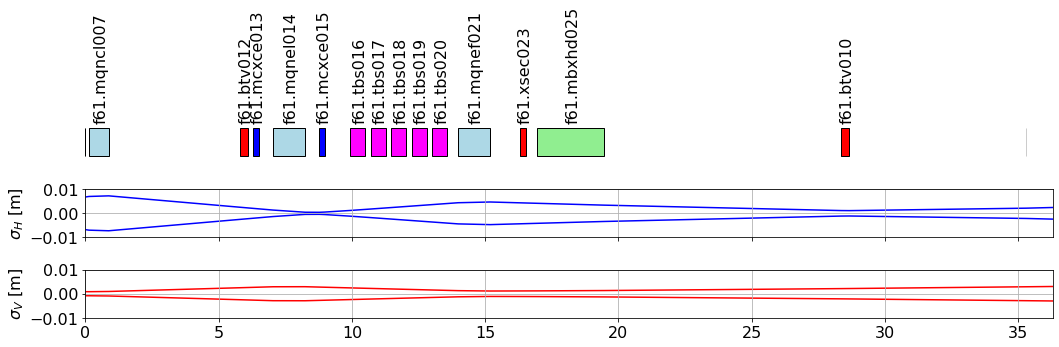

In [194]:
fontsize = 16

fig, ax = plt.subplots(3,1, figsize=(15,5), tight_layout=True, sharex=True)

draw_synoptic(ax[0], twiss_f61d)
ax[0].set_xlim(0,twiss_f61d.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

ax[1].plot(twiss_f61d['s'], beam_size(twiss_f61d['betx'], twiss_f61d['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss_f61d['s'], -beam_size(twiss_f61d['betx'], twiss_f61d['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
draw_aperture_circle(ax[1], twiss_f61d, "aper_1")
draw_aperture_rectangle(ax[1], twiss_f61d, "aper_1")
ax[1].set_xlim(0,twiss_f61d.s[-1])

ax[2].plot(twiss_f61d['s'], beam_size(twiss_f61d['bety'], twiss_f61d['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss_f61d['s'], -beam_size(twiss_f61d['bety'], twiss_f61d['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)
draw_aperture_circle(ax[2], twiss_f61d, "aper_1")
draw_aperture_rectangle(ax[2], twiss_f61d, "aper_2")
ax[2].set_xlim(0,twiss_f61d.s[-1])

ax[1].grid()
ax[1].set_ylim(-0.01, 0.01)
ax[1].set_ylabel(r"$\sigma_{H}$ [m]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(-0.01, 0.01)
ax[2].set_ylabel(r"$\sigma_{V}$ [m]", fontsize=fontsize)

# pybobyqa

In [240]:
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("DUMPWALL : MARKER;")
madx.input('SEQEDIT, sequence=f61d;')
madx.input('FLATTEN;')
madx.command.install(element = 'DUMPWALL', at=2.8, from_="F61.BTV010")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="dumpwall"

# Py-BOBYQA
from __future__ import print_function
import pybobyqa

# Define the objective function
def rosenbrock(x):
    
    print(x)
    
    k_qfn01 = x[0]
    k_qdn02 = x[1]
    k_qfn03 = x[2]

    madx.input("kQFN1 = "+str(k_qfn01)+";")
    madx.input("kQDN2 = "+str(k_qdn02)+";")
    madx.input("kQFN3 = "+str(k_qfn03)+";")

    madx.use(sequence="f61d")
    twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )
    V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )
    
    print (H_sigma_madx)
    print (V_sigma_madx)
    
    return H_sigma_madx*V_sigma_madx

# Define the starting point
x0 = np.array([0.4797, -0.173, 0.1986])

# Define bound constraints (lower <= x <= upper)
lower = np.array([0, -k1(537, "Q120C", Brho), 0])
upper = np.array([k1(733, "Q74L", Brho), 0, k1(421, "QFL", Brho)])

# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(rosenbrock, x0, bounds=(lower,upper), seek_global_minimum=True)

# Display output
print(soln)

[ 0.4797 -0.173   0.1986]
0.0012214267683299342
0.0024446678503865413
[ 0.53823016 -0.173       0.1986    ]
0.00826176927012792
0.00245476410445661
[ 0.4797 -0.073   0.1986]
0.001188924454731746
0.019195690689592062
[ 0.4797     -0.173       0.21589946]
0.00218752405706648
0.002699716251806258
[ 0.3797 -0.173   0.1986]
0.014017615916359055
0.0027229787969705833
[ 0.4797     -0.22197406  0.1986    ]
0.0012675614442053105
0.008316394978646184
[ 0.4797 -0.173   0.0986]
0.008917430616120296
0.002330490588763583
[ 0.47278279 -0.16489956  0.17870171]
0.0024766759295884403
0.0027109518335947766
[ 0.47330457 -0.16549087  0.19975791]
0.0014185716317455942
0.0031141843760351174
[ 0.47774902 -0.1773641   0.1971343 ]
0.0012441862209278186
0.002342561052091554
[ 0.48017518 -0.17785512  0.19678404]
0.0011932731555045761
0.0023377296094257167
[ 0.48255057 -0.17744433  0.19612164]
0.001202114499203847
0.002320031866301842
[ 0.48213624 -0.17707551  0.19528959]
0.0011702299377933825
0.002313671805913271

0.000640237974195004
0.0019336994991484664
[ 0.53823003 -0.17417357  0.16217345]
0.0006402384129512944
0.0019336999524580856
[ 0.53823016 -0.17417361  0.16217352]
0.0006402377713116969
0.0019337001131476171
[ 0.53823016 -0.17417365  0.16217342]
0.0006402379584867755
0.0019336995465813417
[ 0.53823016 -0.17417366  0.16217342]
0.0006402379562920432
0.001933699553209845
[ 0.53823014 -0.17417366  0.16217342]
0.0006402380388095569
0.0019336996184497347
[ 0.53823016 -0.17417367  0.16217343]
0.0006402379297641105
0.0019336996333482557
[ 0.53823016 -0.17417367  0.16217342]
0.0006402379677652359
0.0019336995185675915
[ 0.53823015 -0.17417367  0.16217342]
0.0006402380000509034
0.001933699559832637
[ 0.53823016 -0.17417365  0.16217343]
0.0006402379423876358
0.0019336996065615908
[ 0.53823016 -0.08983202  0.21589946]
0.011430924188758547
0.01908922076312479
[ 0.44087463 -0.06698689  0.21589946]
0.004145562280340982
0.02028903651949364
[0.49827952 0.         0.16880983]
0.0014633589855937207
0.0304

0.000721936250286931
0.0020175954502039757
[ 0.52258903 -0.17509597  0.16552578]
0.0007239269442334595
0.002004113485021443
[ 0.52310872 -0.17514604  0.16527836]
0.0007258084833600332
0.002002212217244426
[ 0.52237108 -0.17509581  0.16499072]
0.0007614631132165505
0.0020026662439769556
[ 0.52286657 -0.17509876  0.16603249]
0.0007032800042974426
0.002005388329299614
[ 0.52510607 -0.17472974  0.16559754]
0.0006901381840724036
0.0019922634012836766
[ 0.53139099 -0.16851777  0.1628841 ]
0.0006933092597726293
0.0021730827054485145
[ 0.5253246  -0.17588458  0.16457624]
0.0007184185474344136
0.0020085498586957557
[ 0.52946571 -0.17423198  0.1641454 ]
0.0006736236288135831
0.0019691686971151623
[ 0.5371773  -0.17475388  0.16161084]
0.0006708337985063854
0.0019373774374393071
[ 0.53727168 -0.17476565  0.16157891]
0.000671242243707421
0.001937092703934002
[ 0.53714371 -0.17479894  0.16152813]
0.000677030048591676
0.0019376649577529017
[ 0.5372064  -0.17473036  0.16170358]
0.0006647263460338428
0

0.0005227355477881193
0.002254654492535273
[ 0.33456875 -0.15739445  0.11688276]
0.0005225947139303119
0.0022506700628094553
[ 0.33447706 -0.15733897  0.11687783]
0.0005224810778006859
0.0022512404036554253
[ 0.33461106 -0.15733703  0.11679901]
0.0005231387832184363
0.0022500551336394454
[ 0.3345301  -0.15748708  0.11692776]
0.0005223926379880804
0.0022507563460524758
[ 0.3348458  -0.15779179  0.11696073]
0.0005227919335594719
0.0022487213571118305
[ 0.33518534 -0.15807109  0.11694322]
0.0005232652980698369
0.0022466529664349594
[ 0.33501914 -0.15793651  0.11694787]
0.0005230263370356589
0.0022475771999973474
[ 0.33496566 -0.15789786  0.11695382]
0.0005229458053053995
0.002247920148089004
[ 0.3348759  -0.15803617  0.11694775]
0.0005228072935050814
0.0022478809340242137
[ 0.33497117 -0.15815669  0.11700796]
0.0005227110918078104
0.0022478544498292885
[ 0.33506928 -0.15820175  0.11698688]
0.0005229029475723551
0.002247264528511071
[ 0.33492089 -0.15814482  0.11702683]
0.00052261048708511

0.5017876349521018
2.306638121516807


Text(0, 0.5, '$\\sigma_{V}$ [m]')

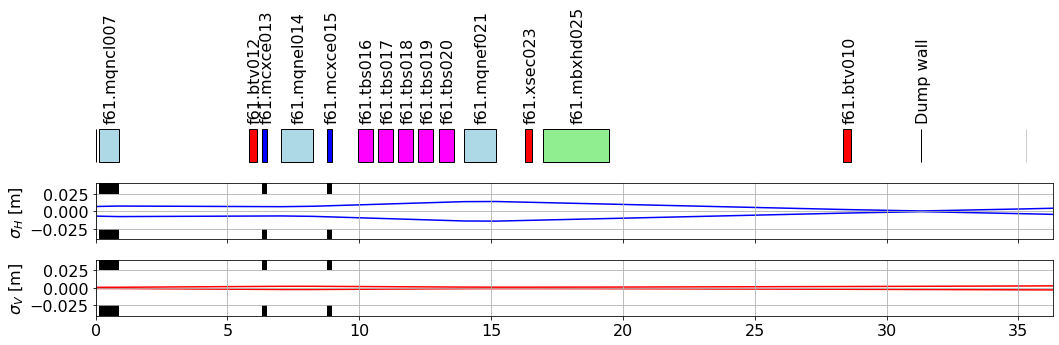

In [241]:
#################################### Initialize MADX ####################################
with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.ele")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.str")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.seq")
madx.call("/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/f61d/f61d.dbx")

ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",exn=exn,eyn=eyn)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE, APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

madx.input('SEQEDIT, SEQUENCE=f61d;')
madx.input('FLATTEN;')
madx.input('REMOVE, ELEMENT=ARBMATRIX;')
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

madx.input("DUMPWALL : MARKER;")
madx.input('SEQEDIT, sequence=f61d;')
madx.input('FLATTEN;')
madx.command.install(element = 'DUMPWALL', at=2.8, from_="F61.BTV010")
madx.input('FLATTEN;')
madx.input('ENDEDIT;')

btv="dumpwall"

H_sigma_madx = []
V_sigma_madx = []

k_qfn01 = soln.x[0]
k_qdn02 = soln.x[1]
k_qfn03 = soln.x[2]

madx.input("kQFN1 = "+str(k_qfn01)+";")
madx.input("kQDN2 = "+str(k_qdn02)+";")
madx.input("kQFN3 = "+str(k_qfn03)+";")


madx.use(sequence="f61d")
twiss_f61d = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

H_sigma_madx = ( beam_size(twiss_f61d['betx'][btv], twiss_f61d['dx'][btv], ex, sige, 1) )*1000
V_sigma_madx = ( beam_size(twiss_f61d['bety'][btv], twiss_f61d['dy'][btv], ey, sige, 1) )*1000

print (H_sigma_madx)
print (V_sigma_madx)
    
fontsize = 16

fig, ax = plt.subplots(3,1, figsize=(15,5), tight_layout=True, sharex=True)

draw_synoptic(ax[0], twiss_f61d)
ax[0].set_xlim(0,twiss_f61d.s[-1])
ax[0].set_ylim(-0.01,1.)
ax[0].axis("off")

ax[1].plot(twiss_f61d['s'], beam_size(twiss_f61d['betx'], twiss_f61d['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss_f61d['s'], -beam_size(twiss_f61d['betx'], twiss_f61d['dx'], ex, sige, 1), alpha=1.0, color ="b", zorder=0)
draw_aperture_circle(ax[1], twiss_f61d, "aper_1")
draw_aperture_rectangle(ax[1], twiss_f61d, "aper_1")
ax[1].set_xlim(0,twiss_f61d.s[-1])

ax[2].plot(twiss_f61d['s'], beam_size(twiss_f61d['bety'], twiss_f61d['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss_f61d['s'], -beam_size(twiss_f61d['bety'], twiss_f61d['dy'], ey, sige, 1), alpha=1.0, color ="r", zorder=0)
draw_aperture_circle(ax[2], twiss_f61d, "aper_1")
draw_aperture_rectangle(ax[2], twiss_f61d, "aper_2")
ax[2].set_xlim(0,twiss_f61d.s[-1])

ax[1].grid()
ax[1].set_ylim(-0.04, 0.04)
ax[1].set_ylabel(r"$\sigma_{H}$ [m]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(-0.04, 0.04)
ax[2].set_ylabel(r"$\sigma_{V}$ [m]", fontsize=fontsize)

In [246]:
print(soln.x[0])
print(soln.x[1])
print(soln.x[2])
print("")
print(current(soln.x[0],"Q74L",Brho))
print(current(-soln.x[1],"Q120C",Brho))
print(current(soln.x[2],"QFL",Brho))

0.32435110560621916
-0.15901384393239995
0.11912984454736843

408.6195724729677
371.03754828960945
222.95159132411683


In [243]:
print(H_sigma_madx)
print(V_sigma_madx)
np.pi*H_sigma_madx*V_sigma_madx

0.5017876349521018
2.306638121516807


3.636212816267903